<h3>Harmony analysis notebook</h3>

<h4>Table of contents</h4>
<br/>
<a href='#intro'>Introduction</a>
<br/>
<a href='#data'>Loading and normalizing data</a>
<br/>
<a href='#pre'>Harmony augmented affinity matrix</a>
<br/>
<a href='#vis'>Visualization using force directed layouts</a>
<br/>
<a href='#pr'>Palantir trajectory detection</a>
<br/>
<a href='#mg'>MAGIC imputation</a>
<br/>
<a href='#vs'>Visualizing gene expression</a>
<br/>
<a href='#trends'>Gene expression trends</a>

<a id="intro"></a><h3> Introduction </h3>

Harmony is a framework for data visualization, trajectory detection and interpretation for scRNA-seq data measured at discrete timepoints. Harmony constructs an augmented affinity matrix by augmenting the kNN graph affinity matrix with mutually nearest neighbors between successive time points. This augmented affinity matrix forms the basis for generated a force directed layout for visualization and also serves as input for computing the diffusion operator which can be used for trajectory detection using Palantir

<a id="data"></a><h3> Loading and normalizing data </h3>

Harmony reads in csv files of counts matrices from multiple time points. Please ensure that replicates of the same time point are consecutive in order

In [1]:
import harmony
import palantir

# Plotting and miscellaneous imports
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Initialize random seed
import random
random.seed(101)

%matplotlib inline

Sample csv files are available at `<harmony directory>/data/`. This folder contains two replicates each of the mouse embryonic development cells at E3.5 and E4.5 stages.

These cells represent a subset of the mouse endoderm dataset and are the cells used for Palantir trajectory detection in Figure 2 of the manuscript.

Assuming that Harmony was downloaded at `~/repositories/Harmony`, the following snippet can be used to load the counts matrices. `sample_names` parameter is used to set a prefix for the barcodes.

In [2]:
# Load sample data
harmony_dir = os.path.expanduser('~/repositories/Harmony/data/')
csv_files = [harmony_dir + 'Lib1-3_E3.5.csv',
            harmony_dir + 'Lib1-4_E3.5.csv',
            harmony_dir + 'Lib1-1_E4.5.csv',
            harmony_dir + 'Lib1-2_E4.5.csv',]
sample_names = ['E3.5_Rep1', 'E3.5_Rep2', 'E4.5_Rep1', 'E4.5_Rep2']

counts = harmony.utils.load_from_csvs(csv_files, sample_names)

Loading count matrices...
E3.5_Rep1
E3.5_Rep2
E4.5_Rep1
E4.5_Rep2
Concatenating data..


<b>Note: </b> Harmony assumes that the cells from the same time point are consecutive to each other in the counts matrix. 

<h4> Normalization </h4>

The next step is to correct for molecule count distribution. Harmony divides the counts of each cell by the total molecules detected as a normalization  technique

In [3]:
norm_df = harmony.utils.normalize_counts(counts)

<h4> Gene selection </h4>

Highly variable genes can be selected using the `hvg_genes` function of Harmony

In [4]:
hvg_genes = harmony.utils.hvg_genes(norm_df)

<h4> Log tranform </h4>

Data can be optionally log transformed. Note that, some datasets show better signal in the linear scale while others show stronger signal in the log scale. We use log transformation for this dataset and use the highly variable genes in the above step as the input data

In [5]:
data_df = harmony.utils.log_transform(norm_df.loc[:,hvg_genes])

<a id='pre'></a><h3>Harmony augmented affinity matrix</h3>

The following metadata information is necessary for Harmony
1. Timepoint at which each cell was measured
2. Connections between timepoints for computation of mutually nearest neighbors


The timepoint at which each cell was measured for this dataset can be determined by string matching since the information has been added to the barcode name

In [6]:
tp = pd.Series(index=data_df.index)
for t in ['E3.5', 'E4.5']:
    cells = data_df.index[data_df.index.str.contains(t)]
    tp[cells] = t

The connection between E3.5 and E4.5 can be added as follows

In [7]:
timepoint_connections = pd.DataFrame(columns=[0, 1])
index = 0
timepoint_connections.loc[index, :] = ['E3.5', 'E4.5']; index += 1
timepoint_connections

,0,1
0,E3.5,E4.5


Using the above information, the augmented and non-augmented affinity matrices can be computed using

In [8]:
aug_aff, aff = harmony.core.augmented_affinity_matrix(data_df, tp, timepoint_connections)

Running PCA with 235 components
Nearest neighbor computation...
Constucting affinities between E3.5 and E4.5...
t+1 neighbors of t...
t neighbors of t+1...


/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


<a id='vis'></a><h3>Visualization using force directed layouts</h3>

The relationships between timepoints can be visualized using a force directed layout. This layout can be computed using the following function

In [9]:
layout = harmony.plot.force_directed_layout(aug_aff, data_df.index)

100%|██████████| 500/500 [00:02<00:00, 166.70it/s]

BarnesHut Approximation  took  0.99  seconds
Repulsion forces  took  1.62  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.12  seconds
AdjustSpeedAndApplyForces step  took  0.12  seconds


For consistency, tmhe following snippet loads the precomputed tSNE projections.

In [10]:
layout = pd.read_pickle(harmony_dir + '/e35_e45_layout.p')

The different timepoints can be visualized using

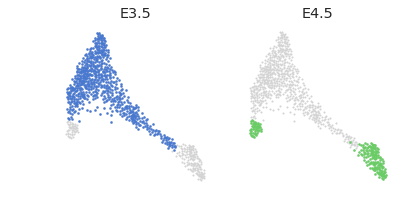

In [11]:
harmony.plot.plot_timepoints(layout, tp)

<a id='pr'></a><h3>Palantir trajectory detection</h3>

<a href=" https://github.com/dpeerlab/Palantir">Palantir</a> is an algorithm developed by the Pe'er lab to align cells along differentiation trajectories. Palantir models differentiation as a stochastic process where stem cells differentiate to terminally differentiated cells by a series of steps through a low dimensional phenotypic manifold. Palantir effectively captures the continuity in cell states and the stochasticity in cell fate determination.

The first step in Palantir trajectory detection is to project data onto diffusion maps. Harmony augmented affinity matrix is used as the input for identifying diffusion maps. Please see https://github.com/dpeerlab/Palantir for more details on Palantir

In [12]:
dm_res = palantir.utils.run_diffusion_maps(aug_aff)
ms_data = palantir.utils.determine_multiscale_space(dm_res)
ms_data.index = data_df.index

Run Palantir with a Nanog hi cells as the start

In [13]:
# Start cell
start_cell = 'E3.5_Rep2_Lib1-4_E3.5_192121092393820'
# Terminal cells
terminal_cells = [ 'E4.5_Rep1_Lib1-1_E4.5_161864255428444',
    'E4.5_Rep2_Lib1-2_E4.5_239475375884140']

pr_res = palantir.core.run_palantir(ms_data, start_cell, terminal_cells,
                use_early_cell_as_start=True)

Sampling and flocking waypoints...
Time for determining waypoints: 0.0027246673901875815 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.05793136755625407 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


Rename branch probabilities

In [14]:
pr_res.branch_probs.columns = ['PrE', 'EPI']

Palantir results can be visualized using the following function

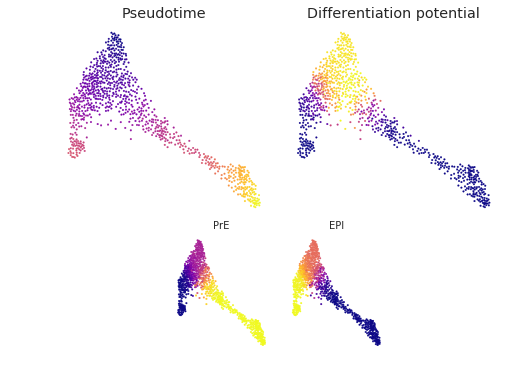

In [15]:
palantir.plot.plot_palantir_results(pr_res, layout)

<a id='mg'></a><h3>MAGIC imputation</h3>

<a href="https://github.com/pkathail/magic">MAGIC</a> is an imputation technique developed in the Pe'er lab for single cell data imputation. Palantir uses MAGIC to impute the data for visualization and determining gene expression trends.

In [16]:
imp_df = palantir.utils.run_magic_imputation(data_df, dm_res)

<a id='vs'></a><h3>Visualizing gene expression</h3>

Gene expression can be visualized on force directed layouts using the Palantir `plot_gene_expression` function. The `genes` parameter is an string iterable of genes, which are a subset of the expression of column names. The below function plots the expression of EPI gene `FGF4` and PrE gene `GATA4`.

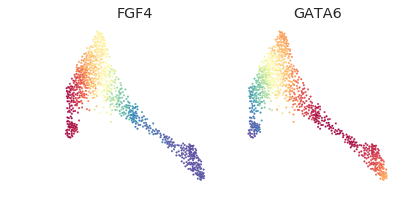

In [17]:
palantir.plot.plot_gene_expression(imp_df, layout, ['FGF4', 'GATA6'])

Timepoint wise gene expression can be visualized using the corresponding Harmony `plot_tp_gene_expression` function

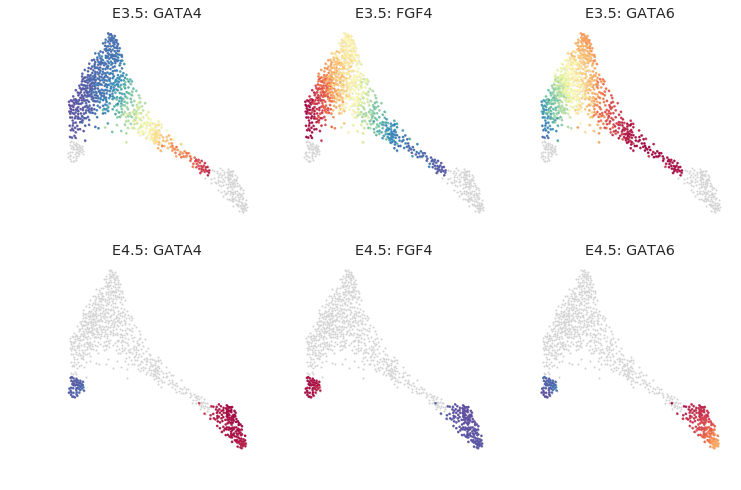

In [18]:
harmony.plot.plot_tp_gene_expression(imp_df, layout, ['FGF4', 'GATA4', 'GATA6'], tp)

<a id='trends'></a><h3> Gene expression trends </h3>

Gene expression trends along Palantir inferred pseudo-time can be plotted as below. Palantir uses <a href="https://cran.r-project.org/web/packages/gam/">Generalized Additive Models (GAMs) </a> to determine the gene expression trends along different lineages. The marker trends can be determined using the following snippet. This computes the trends for all lineages. A subset of lineages can be used using the `lineages` parameter.


In [19]:
genes = ['GATA6', 'FGF4']
gene_trends = palantir.presults.compute_gene_trends( pr_res, imp_df.loc[:, genes])

PrE
Time for processing PrE: 0.008556771278381347 minutes
EPI
Time for processing EPI: 0.008600835005442302 minutes


The determined trends can be visualized with the `plot_gene_trends` function. A separate panel is generated  for each gene

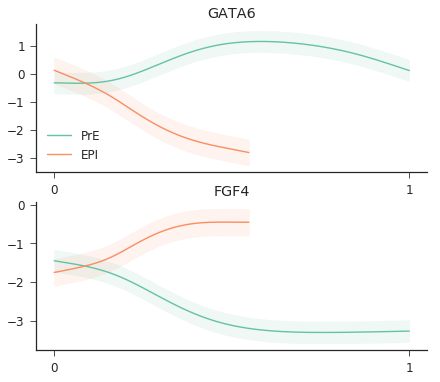

In [20]:
palantir.plot.plot_gene_trends(gene_trends)

Please see https://github.com/dpeerlab/Palantir for plotting utilities from Palantir